In [17]:
import glob
import os
import warnings
import scanpy as sc
import pandas as pd
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import numpy as np

In [18]:
warnings.simplefilter(action="ignore",category=Warning)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [19]:
workpath = "/home/maomin/material/JupyterLabworkspace/BreastCancer/GSE161529/"

In [20]:
adata = sc.read_h5ad(workpath + "Result/01adata_qc.h5ad")

In [21]:
print(f"{adata.X.min()}\n{adata.X.max()}") 

0.0
23329.0


In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:01)


In [23]:
print(f"{adata.X.min()}\n{adata.X.max()}") 

0.0
9.020427703857422


extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


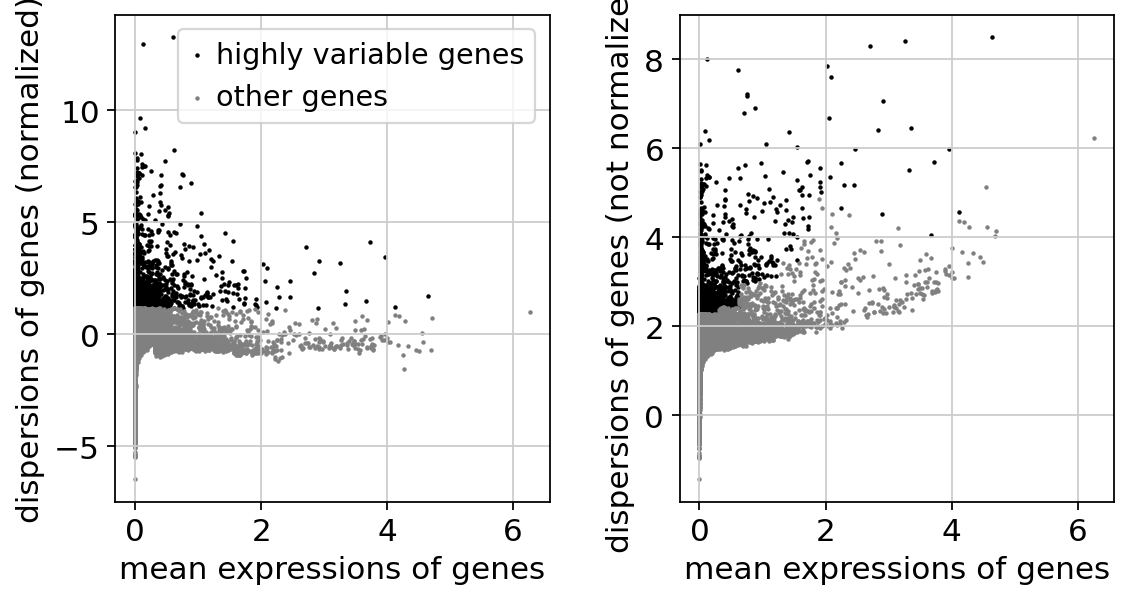

In [24]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000,min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [25]:
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['pct_counts_mt'])

regressing out ['pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:18:01)


In [26]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

computing PCA
    with n_comps=50
    finished (0:01:20)


In [27]:
sc.external.pp.bbknn(adata,batch_key='ID')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:05:31)


In [28]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:11:34)


In [29]:
sc.tl.leiden(adata,resolution=0.2,key_added='louvain 0.2')

running Leiden clustering
    finished: found 10 clusters and added
    'louvain 0.2', the cluster labels (adata.obs, categorical) (0:25:52)


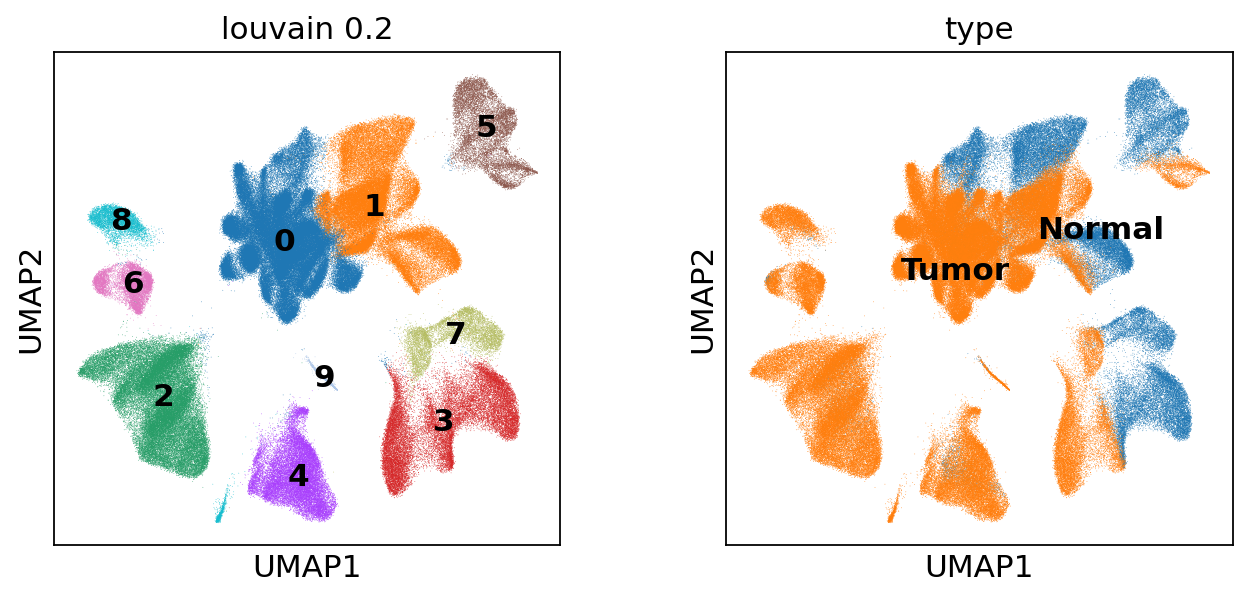

In [30]:
sc.pl.umap(adata, color=['louvain 0.2', 'type'],legend_loc= 'on data')

In [32]:
sc.pl.umap(adata, color=['louvain 0.2',"EPCAM","KRT18","KRT14","PLVAP",
                         'PECAM1', "CD79A","JCHAIN","TPSAB1","TPSB2",
                         'LYZ','CD68', "CD3D","GNLY","DCN",'COL3A1',"RGS5"],ncols=4, 
           wspace=0.25, legend_loc="on data")

In [33]:
clustercelltype = {
    '0': 'Epithelial',
    '1': 'Epithelial',
    "2": 'T/NK',
    '3': 'CAFs',
    '4': 'Myeloid',
    '5': 'Endothelial',
    '6': 'B',
    '7': 'PVL',
    '8': 'B',
    '9': 'Mast',
}

In [34]:
adata.obs['celltype'] = adata.obs['louvain 0.2'].map(clustercelltype)

In [35]:
adata.write_h5ad("./02adata_bbknnall.h5ad", compression="gzip")

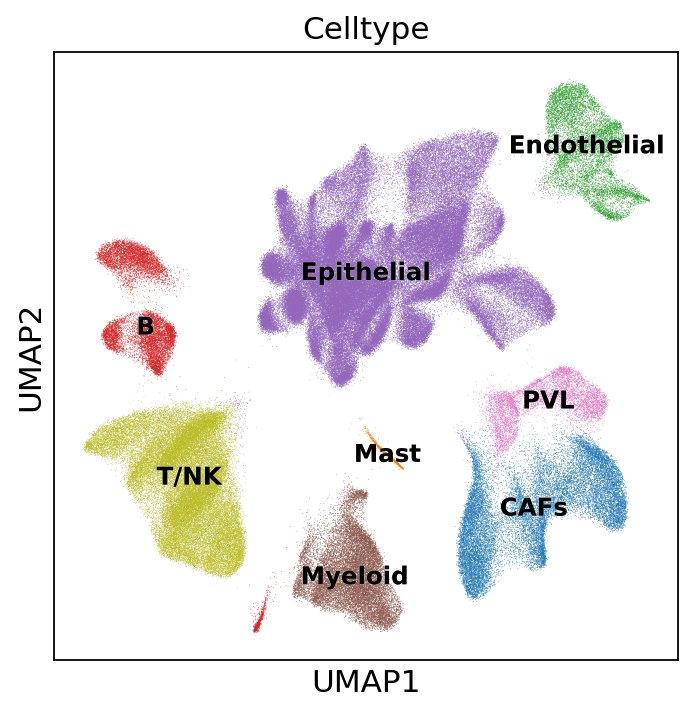

In [36]:
with rc_context({"figure.figsize": (5, 5)}):
  sc.pl.umap(adata,
        color="celltype",
        #add_outline=True,
        legend_loc="on data",
        legend_fontsize=11,
        legend_fontoutline=0.2,
        #size= 0.3,
        frameon=True,return_fig=True,
        palette={'B':"#D62728FF",'CAFs':"#1F77B4FF","Endothelial":"#2CA02CFF",
                 'Epithelial':"#9467BDFF",'Mast':"#FF7F0EFF","Myeloid":"#8C564BFF",
                 "PVL":"#E377C2FF","T/NK":"#BCBD22FF",},
        #palette='Set1',
        title="Celltype")
plt.savefig('./figures/FigureUmapnew.pdf',dpi=600)

In [37]:
split = adata.obs['type'].unique().tolist()
n_split = len(split)

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=n_split, squeeze=False, figsize=(5.5*n_split, 5))
for i in range(n_split):
     tmp = adata[adata.obs['type'] == split[i], :]
     sc.pl.umap(tmp, color='celltype', ax=ax[0, i], show=False,palette={'B':"#D62728FF",'CAFs':"#1F77B4FF","Endothelial":"#2CA02CFF",
                 'Epithelial':"#9467BDFF",'Mast':"#FF7F0EFF","Myeloid":"#8C564BFF",
                 "PVL":"#E377C2FF","T/NK":"#BCBD22FF",},legend_loc="on data",legend_fontsize=11)
     ax[0, i].set_title(f"{split[i]}")
plt.savefig('./figures/FigureUmap2new.pdf',dpi=600)

In [40]:
marker_genes_dict = {
    'Epithelial': ["EPCAM","KRT18","KRT14"],
    "T/NK": ["CD3D","GNLY"],
    "CAFs": ["DCN",'COL3A1'],
    'PVL': ["RGS5"],
    'Myeloid': ['LYZ','CD68'],
    'Endothelial': ["PLVAP",'PECAM1'],
    'B':["CD79A","JCHAIN"],
    'Mast':["TPSAB1","TPSB2"],  
}

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_celltype']`


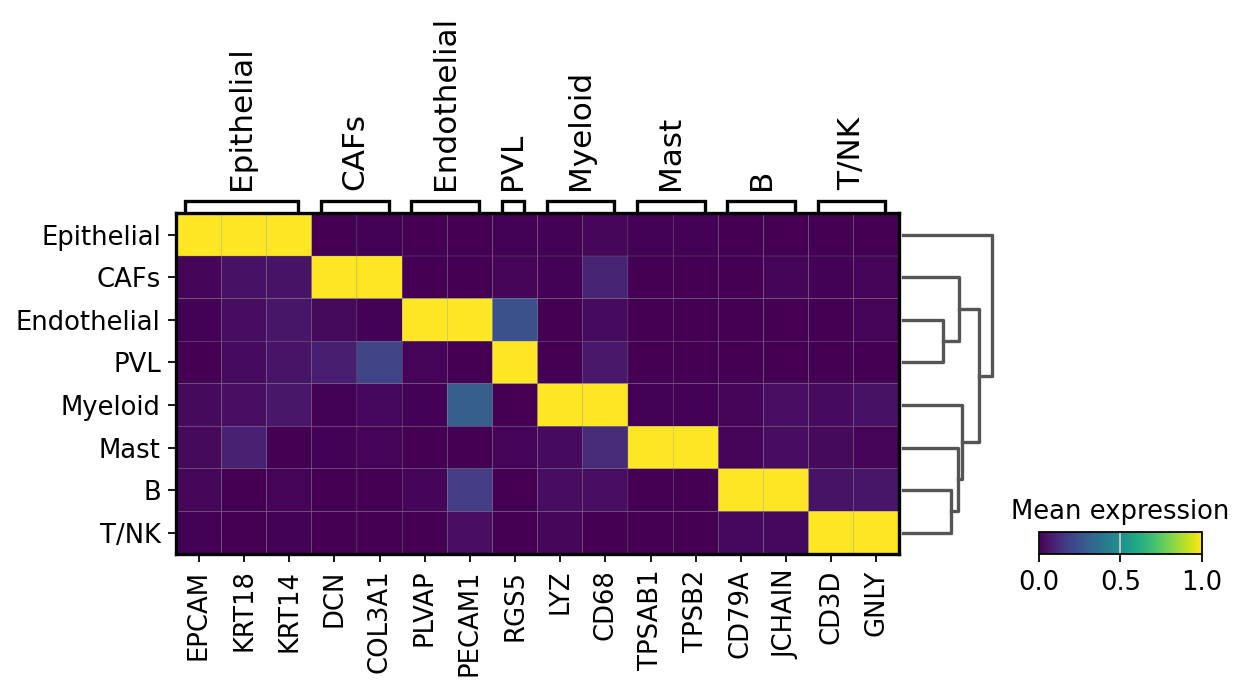

In [42]:
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.matrixplot(adata,marker_genes_dict,"celltype",save=True,
                     dendrogram=True,cmap="viridis",standard_scale="var",colorbar_title="Mean expression")